## Predictions using fine-tuned DistilBERT model
This model has been fine-tuned by using the training data, and then saved and loaded here.


In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [6]:
# The dataset can be provided upon request
df = pd.read_csv("frikk_eirik_dataset.csv")

In [7]:
df.head()

,username,display_name,text_document,user_created_at,bio,location,target
0,00110z,caged,MENTION MENTION yet we do its sad what were do...,2017-09-14 07:04:22,losing fat no matter what gw lighter than yest...,NaN,pro_ed
1,0Riles,rilès EMOJIHourglassWithFlowingSand,you want to go but dont want to stay you want ...,2014-03-24 22:21:03,hypsibius dujardini URL mgmtbookingMENTION ...,NaN,unrelated
2,0_pluto_0,EMOJIGlowingStar nessa EMOJIGlowingStar,MENTION you deserve an amazing sleep and sweet...,2017-09-02 04:21:15,my multifandom ass cant have a specific fandom...,Probably Youtube,unrelated
3,0bessivley_thin,EMOJIRose no one EMOJIRose,rt MENTION i like a girl that can eat no you ...,2017-07-27 00:07:26,sw lbs cw gw gw gw ugw avi is not me,Washington USA,pro_ed
4,0hskinnylove,EMOJIUnfilledHeart,MENTION i think i have to have grapefruit cos ...,2013-08-19 09:28:04,currently self destructing,NaN,pro_ed


unrelated       0.565064
pro_ed          0.336020
pro_recovery    0.098916
Name: target, dtype: float64

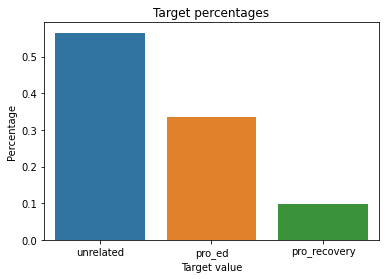

In [10]:
# Check distribution of target variable
target_value_percentage = df["target"].value_counts() / len(df)

# Plot count of values in target-column
sns.barplot(x=target_value_percentage.index, y=target_value_percentage.values)
plt.title("Target percentages")
plt.ylabel("Percentage")
plt.xlabel("Target value")

target_value_percentage

In [11]:
# For this experiment, only the text-documents are used as features
X, y = df['text_document'], df["target"]

In [13]:
# We split the data, but only need test data as we are doing predictions
_, X_test, _, y_test = train_test_split(X, y, train_size=0.8, random_state=42, stratify=df['target'])

In [14]:
# Make sure all data is strings
X_test = X_test.values.tolist()
for i in range(len(X_test)):
    X_test[i] = str(X_test[i])

In [15]:
# Change each label into numerical class labels
labels_dict = {'unrelated': 0, 'pro_ed': 1, 'pro_recovery': 2}

y_test = y_test.values.tolist()
for i in range(len(y_test)):
    y_test[i] = labels_dict[y_test[i]]

In [16]:
# Initialize the tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [17]:
# Create tokenized encodings
test_encodings = tokenizer(X_test, truncation=True, padding=True)

In [18]:
# Convert encodings to numpy array
test_data = np.array(list(dict(test_encodings).values()))

In [19]:
# Initialize model
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_transform', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_19', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [20]:
# Get model checkpoint from latest epoch (epochs=5 here)
checkpoint_path = "training_ckpt2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [21]:
# Load model weights from training
latest = tf.train.latest_checkpoint(checkpoint_dir)
model.load_weights(latest)

In [22]:
# Show model summary
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  66362880  
_________________________________________________________________
pre_classifier (Dense)       multiple                  590592    
_________________________________________________________________
classifier (Dense)           multiple                  2307      
_________________________________________________________________
dropout_19 (Dropout)         multiple                  0         
Total params: 66,955,779
Trainable params: 66,955,779
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Do predictions
preds = model.predict(test_data[0])

In [24]:
# Take argmax to get label from predictions
predictions = np.argmax(preds, axis=-1)

# Show classification metrics
clf_report = classification_report(y_test, predictions[0], digits=3)
print(clf_report)

              precision    recall  f1-score   support

           0      0.982     0.977     0.979       771
           1      0.985     0.983     0.984       459
           2      0.864     0.896     0.880       135

    accuracy                          0.971      1365
   macro avg      0.944     0.952     0.948      1365
weighted avg      0.971     0.971     0.971      1365



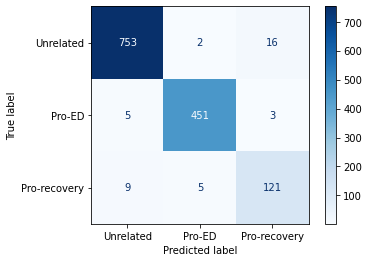

In [26]:
# Plot confusion matrix
conf_mat = confusion_matrix(y_test, predictions[0])
cmd = ConfusionMatrixDisplay(conf_mat, display_labels=['Unrelated','Pro-ED', 'Pro-recovery'])
cmd.plot(cmap='Blues')